## Performing Vader Sentiment analysis on the Text as well as the summaries

In [48]:
# !pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import bs4
import nltk.corpus  
from nltk.text import Text
import spacy
from pandarallel import pandarallel
import multiprocessing
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
widgets.IntSlider()

pd.set_option('max_colwidth', 200)

2023-05-23 19:28:47.006227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 19:28:51.791915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-23 19:28:51.792945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
pandarallel.initialize(nb_workers = 60, use_memory_fs = False)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%%time
df_sent = pd.read_parquet('data_to_sentiment.parquet', engine = 'pyarrow')
df_sent.shape

CPU times: user 34.6 s, sys: 8.85 s, total: 43.5 s
Wall time: 33.8 s


(181958, 15)

#### Initialize the Vader Analyzer

In [4]:
#Load the SentimentIntensityAnalyzer object from the VADER package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Create a handle to the SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

#function that outputs the sentiment ratings
def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{}".format(sent))

In [5]:
#Checking on a sample first

df_sample = df_sent.sample(n = 1000,replace = False)

In [9]:
print_sentiment_ratings(list(df_sample['text_clean'])[14])
print_sentiment_ratings(list(df_sample['summary'])[14])

{'neg': 0.01, 'neu': 0.748, 'pos': 0.242, 'compound': 0.9996}
{'neg': 0.007, 'neu': 0.736, 'pos': 0.257, 'compound': 0.9983}


In [18]:
%%time
df_sample['text_sentiment'] = df_sample['text_clean'].parallel_apply(lambda x: analyzer.polarity_scores(x)["compound"])
df_sample['summary_sentiment'] = df_sample['summary'].parallel_apply(lambda x: analyzer.polarity_scores(x)["compound"])

CPU times: user 249 ms, sys: 6.79 s, total: 7.04 s
Wall time: 9.29 s


In [19]:
print(df_sample['text_sentiment'].describe())
print(df_sample['summary_sentiment'].describe())

count    1000.000000
mean        0.872750
std         0.445475
min        -0.999100
25%         0.992200
50%         0.997500
75%         0.999000
max         0.999900
Name: text_sentiment, dtype: float64
count    1000.000000
mean        0.836764
std         0.476586
min        -0.997400
25%         0.971300
50%         0.991550
75%         0.996400
max         0.999700
Name: summary_sentiment, dtype: float64


In [20]:
df_sample['text_sent_score'] = df_sample['text_sentiment']
df_sample['summary_sent_score'] = df_sample['summary_sentiment']
# Create a positive / negative sentiment variable
df_sample['text_sentiment'] = np.where(df_sample['text_sent_score'].astype('float') > 0, 'Positive', 'Negative')
df_sample['text_sentiment'] = np.where(df_sample['text_sent_score'].astype('float')== 0, 'Neutral', df_sample['text_sentiment'])

df_sample['summary_sentiment'] = np.where(df_sample['summary_sent_score'].astype('float') > 0, 'Positive', 'Negative')
df_sample['summary_sentiment'] = np.where(df_sample['summary_sent_score'].astype('float') == 0, 'Neutral', df_sample['summary_sentiment'])
df_sample.head(2)

,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len,summary,text_sentiment,summary_sentiment,text_sent_score,summary_sent_score
195107,2022-02-17,2,2022,2022Q1,17,3,Nuvve and 2021.AI Announce Plans to Increase Artificial Intelligence Capabilities of Nuvve's V2G Platform,Nuvve and 2021.AI Announce Plans to Increase Artificial Intelligence Capabilities of Nuvve's V2G Platform\n\nSkip to content2 Strong 4 BulliesShare Your HolidaysCLE WeekendCribbs in the CLEW82TXTD...,Nuvve 2021.AI Announce Plans Increase Artificial Intelligence Capabilities Nuvve V2 G Platform,Nuvve 2021.AI Announce Plans Increase Artificial Intelligence Capabilities Nuvve V2 G Platform Skip content2 Strong BulliesShare Your HolidaysCLE WeekendCribbs CLEW82TXTDealsContestsNewsLiveFirst ...,"[Nuvve, 2021.AI, Announce, Plans, Increase, Artificial, Intelligence, Capabilities, Nuvve, V2G, Platform]","[Nuvve, 2021.AI, Announce, Plans, Increase, Artificial, Intelligence, Capabilities, Nuvve, V2G, Platform, Skip, content2, Strong, BulliesShare, Your, HolidaysCLE, WeekendCribbs, CLEW82TXTDealsCont...",11,1208,The joint venture benamed Astrea AITM Nuvve extensive mobility energy expertise 2021.AI proven AI platform broaden optimize services offered Nuvve V2 G technology today . Nuvve Corporation logo PR...,Positive,Positive,0.9992,0.9969
97921,2023-02-07,2,2023,2023Q1,7,1,"The AI War: Google officially announces Bard to take on ChatGPT, shows off their AI bot in search","\n\nThe AI War: Google officially announces Bard to take on ChatGPT, shows off their AI bot in search\nHi, Sahil Sharma\n\nLogout\nVantage\n\n\nIndia\n\n\nWorld\n\n\nPolitics\n\n\nSports\n\n\nTech...","The AI War Google officially announces Bard ChatGPT , shows AI bot search","The AI War Google officially announces Bard ChatGPT , shows AI bot search Hi , Sahil Sharma Logout Vantage India World Politics Sports Tech Auto Opinion Explainers Entertainment Cricket Budget 202...","[The, AI, War, Google, officially, announces, Bard, take, ChatGPT, shows, AI, bot, search]","[The, AI, War, Google, officially, announces, Bard, take, ChatGPT, shows, AI, bot, search, Hi, Sahil, Sharma, Logout, Vantage, India, World, Politics, Sports, Tech, Auto, Opinion, Explainers, Ente...",14,1315,"Alarm bells Google ChatGPT destroy Google Search years , says Gmail creator The creator Gmail Google AdSense , Paul Buccheit , predicted ChatGPT destroy Google Search , ancillary services years . ...",Positive,Negative,0.9772,-0.5574


In [22]:
print(df_sample['text_sentiment'].value_counts())
print(df_sample['summary_sentiment'].value_counts())

text_sentiment
Positive    940
Negative     60
Name: count, dtype: int64
summary_sentiment
Positive    928
Negative     72
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Sentiments on the entire Text in the Sampled Data')

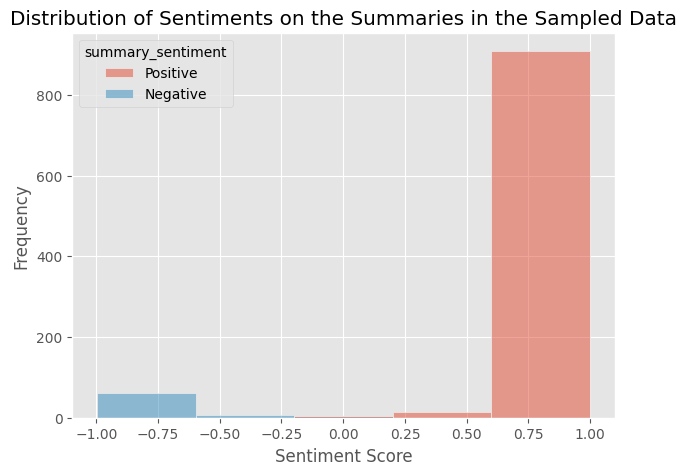

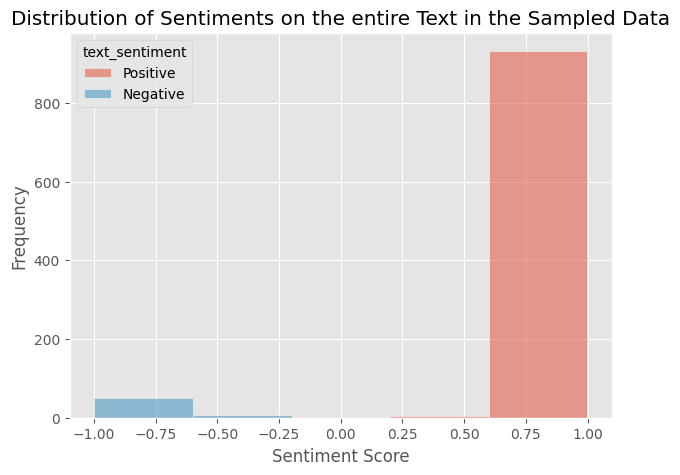

In [24]:
#Plotting the distribution of the sentiments
plt.style.use("ggplot")
plt.figure(figsize = (7,5))
sns.histplot(data = df_sample, x = 'summary_sent_score', bins = 5, hue = 'summary_sentiment' )
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiments on the Summaries in the Sampled Data")

#Plotting the distribution of the sentiments
plt.style.use("ggplot")
plt.figure(figsize = (7,5))
sns.histplot(data = df_sample, x = 'text_sent_score', bins = 5, hue = 'text_sentiment' )
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiments on the entire Text in the Sampled Data")

In [25]:
%%time
##Apply the Vader Analyzer to the complete data to check if the distribution gets more evenly distributed
df_sent['text_sent_score'] = df_sent['text_clean'].parallel_apply(lambda x : analyzer.polarity_scores(x)["compound"])

df_sent['summary_sent_score'] = df_sent['summary'].parallel_apply(lambda x : analyzer.polarity_scores(x)["compound"])

CPU times: user 1.9 s, sys: 9.39 s, total: 11.3 s
Wall time: 4min 46s


In [26]:
df_sent['text_sentiment'] = np.where(df_sent['text_sent_score']>0, "Positive","Negative")
df_sent['text_sentiment'] = np.where(df_sent['text_sent_score']==0, "Neutral",df_sent['text_sentiment'])

df_sent['summary_sentiment'] = np.where(df_sent['summary_sent_score']>0, "Positive","Negative")
df_sent['summary_sentiment'] = np.where(df_sent['summary_sent_score']==0, "Neutral",df_sent['summary_sentiment'])


df_sent.head(2)

,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len,summary,text_sent_score,summary_sent_score,text_sentiment,summary_sentiment
0,2021-03-18,3,2021,2021Q1,18,3,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld...,Artificial intelligence improves parking efficiency Chinese cities People Daily Online,Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Trave...,"[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online]","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online, Home, China, Politics, Foreign, Affairs, Opinions, Video, We, Are, China, Business, Military, Worl...",10,705,"Peoples Daily Online Li Wenming Thanks application artificial intelligence AI empowered roadside electronic toll collection ETC system , Chinas city Beijing seen significant improvement efficiency...",0.9978,0.9960,Positive,Positive
1,2020-02-27,2,2020,2020Q1,27,3,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\n...",Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament,"Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament Skip Thursday , February 27 , 2020 Latest Mansplaining conferences How forestall Drax...","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament]","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament, Skip, content, Thursday, February, 27, 2020, Latest, Mansplaining, ...",17,1208,"Overnight Like Did Italy February 27 , 2020February 27 , 2020 admin News Coronavirus Dettol sales surge markets fall February 27 , 2020February 27 , 2020 Allen Becker Business Levi Strauss marks p...",0.9991,0.9926,Positive,Positive


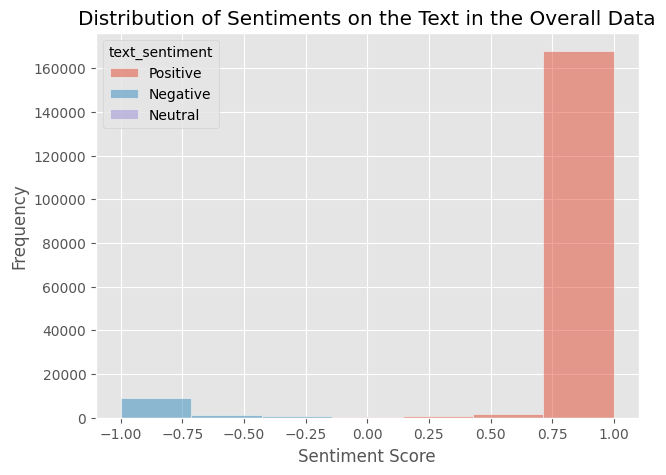

Text(0.5, 1.0, 'Distribution of Sentiments on the Text Summaries in the Overall Data')

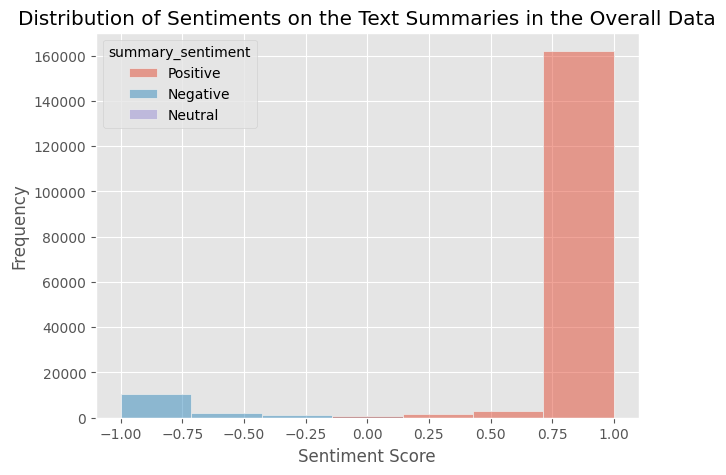

In [27]:
#Plotting the distribution of the sentiments
plt.style.use("ggplot")
plt.figure(figsize = (7,5))
sns.histplot(data = df_sent, x = 'text_sent_score', bins = 7, hue = 'text_sentiment' )
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiments on the Text in the Overall Data")
plt.show()

#Plotting the distribution of the sentiments
plt.style.use("ggplot")
plt.figure(figsize = (7,5))
sns.histplot(data = df_sent, x = 'summary_sent_score', bins = 7, hue = 'summary_sentiment' )
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiments on the Text Summaries in the Overall Data")

In [28]:
print(df_sent.text_sentiment.value_counts())
print(df_sent.summary_sentiment.value_counts())

text_sentiment
Positive    170643
Negative     11280
Neutral         35
Name: count, dtype: int64
summary_sentiment
Positive    167451
Negative     14416
Neutral         91
Name: count, dtype: int64


### Taking sentiments on the summaries is not effective. Hence proceeding with full text

In [29]:
df_sent.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'text_sent_score', 'summary_sent_score',
       'text_sentiment', 'summary_sentiment'],
      dtype='object')

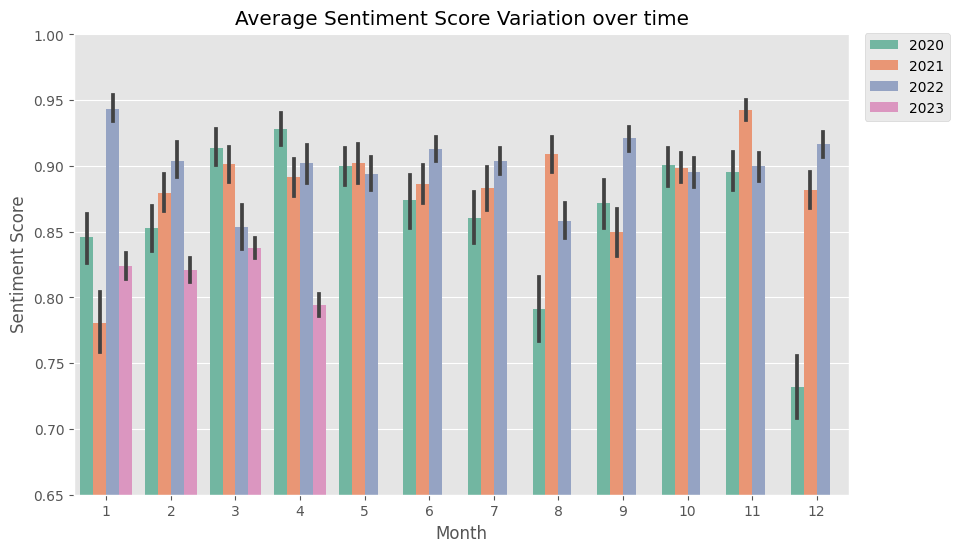

In [35]:
#Plotting the sentiments over time
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data = df_sent, x = 'month', y= 'text_sent_score', hue = "year", palette = "Set2", ax=ax)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, borderaxespad =0.)
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
ax.set_ylim(0.65,None)
plt.title("Average Sentiment Score Variation over time")
plt.show()

In [36]:
df_sent['year'].value_counts()

year
2022    54710
2023    54627
2021    41475
2020    31146
Name: count, dtype: int64

Text(0.5, 1.0, 'Sentiment Variation Over Time')

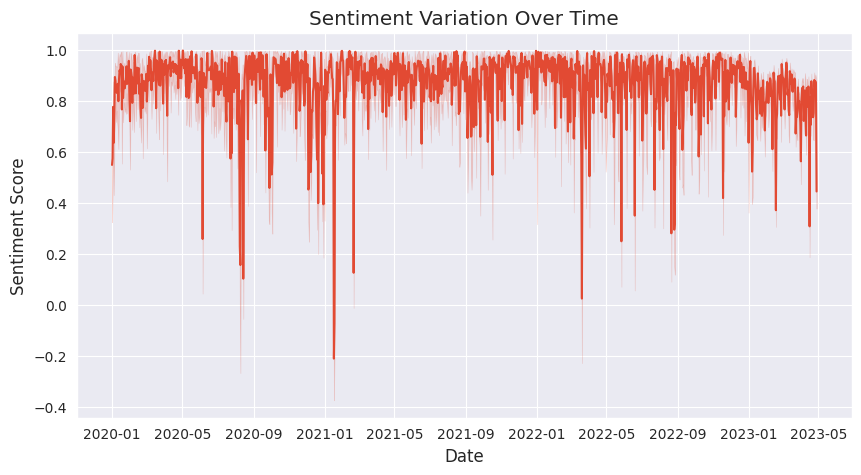

In [39]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.lineplot(data = df_sent, x='date', y= 'text_sent_score')
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Variation Over Time")

In [52]:
%%time
# df_sent = df_sent.drop(['summary_sentiment','summary_sent_score'], axis =1)
df_sent.rename(columns = {'text_sent_score':'sent_score', 'text_sentiment':'sentiment'}, inplace =True)
df_sent.to_parquet('data_vader_final.parquet')

CPU times: user 31.6 s, sys: 5.91 s, total: 37.5 s
Wall time: 43 s


In [53]:
df_sent.shape

(181958, 17)

In [54]:
df_sent.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment'],
      dtype='object')

In [3]:
%%time
df_sent = pd.read_parquet('data_vader_final.parquet', engine = 'pyarrow')

CPU times: user 41.6 s, sys: 10.8 s, total: 52.4 s
Wall time: 1min 4s


Text(0.5, 1.0, 'Quarterly Sentiment Variation')

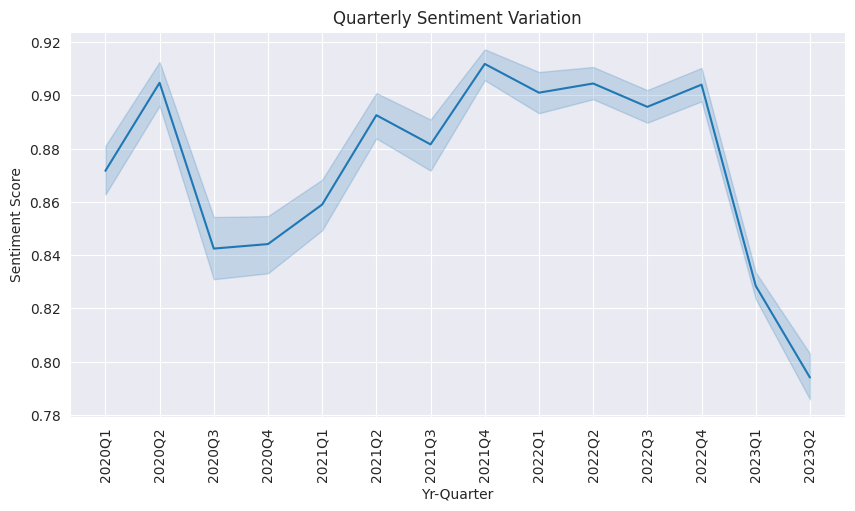

In [4]:
## Quarterly sentiment variation

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
df_sent_sorted = df_sent.sort_values('quarter')  # Sort DataFrame by 'quarter' column
sns.lineplot(data = df_sent_sorted, x=df_sent_sorted['quarter'].astype('str'), y= 'sent_score', color = 'tab:blue')
plt.xlabel("Yr-Quarter")
plt.xticks(rotation = 90)
plt.ylabel("Sentiment Score")
plt.title("Quarterly Sentiment Variation")

In [5]:
# Get the timeline of the overall, positive and negative sentiments.
# Check for the day of week 

In [6]:
df_sent['dayofwk'].value_counts()

dayofwk
1    38367
2    35819
3    35706
0    26932
4    25739
5    10757
6     8638
Name: count, dtype: int64

Text(0.5, 1.0, 'Sentiment Variation by day of the week')

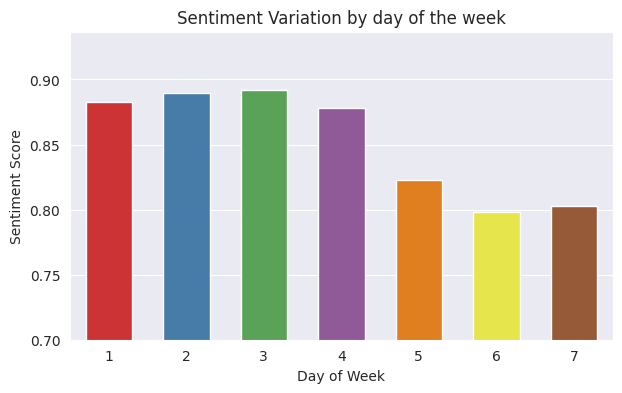

In [7]:
dayofwk= df_sent.groupby('dayofwk')[['sent_score']].agg('mean').reset_index()
dayofwk['dayofwk'] = dayofwk['dayofwk']+1


plt.figure(figsize=(7,4))
sns.set_style('darkgrid')
ax = sns.barplot(data = dayofwk, x='dayofwk',y ='sent_score', palette = 'Set1', width = 0.6 )
plt.xlabel("Day of Week")
ax.set_ylim(0.7, None)
plt.xticks(rotation = 0)
plt.ylabel("Sentiment Score")
plt.title("Sentiment Variation by day of the week")

In [8]:
pos_df = df_sent[df_sent['sentiment']=="Positive"]
neg_df = df_sent[df_sent['sentiment']=="Negative"]

In [9]:
pos_df.shape

(170643, 17)

Text(0.5, 1.0, 'Quarterly Positive Sentiment Variation')

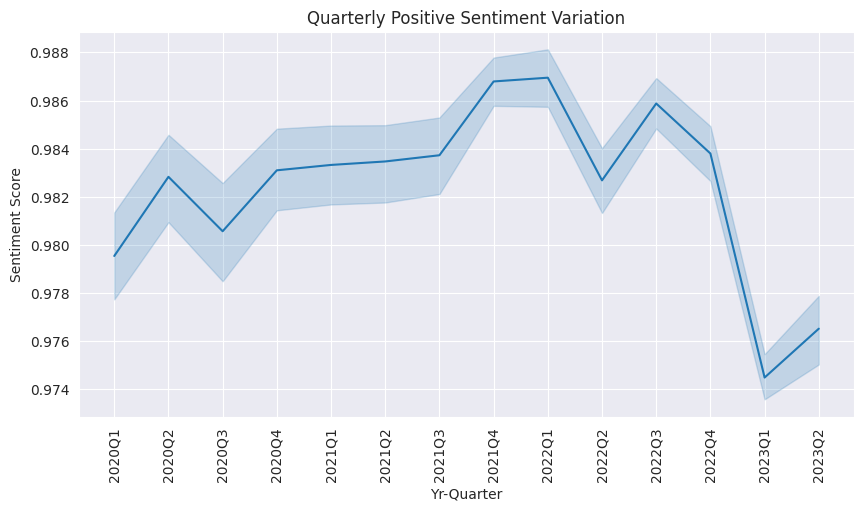

In [10]:
## Quarterly Positive sentiment variation

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
pos_df_sorted = pos_df.sort_values('quarter')  # Sort DataFrame by 'quarter' column
sns.lineplot(data = pos_df_sorted, x=pos_df_sorted['quarter'].astype('str'), y= 'sent_score', color = 'tab:blue')
plt.xlabel("Yr-Quarter")
plt.xticks(rotation = 90)
plt.ylabel("Sentiment Score")
plt.title("Quarterly Positive Sentiment Variation")

Text(0.5, 1.0, 'Quarterly Negative Sentiment Variation')

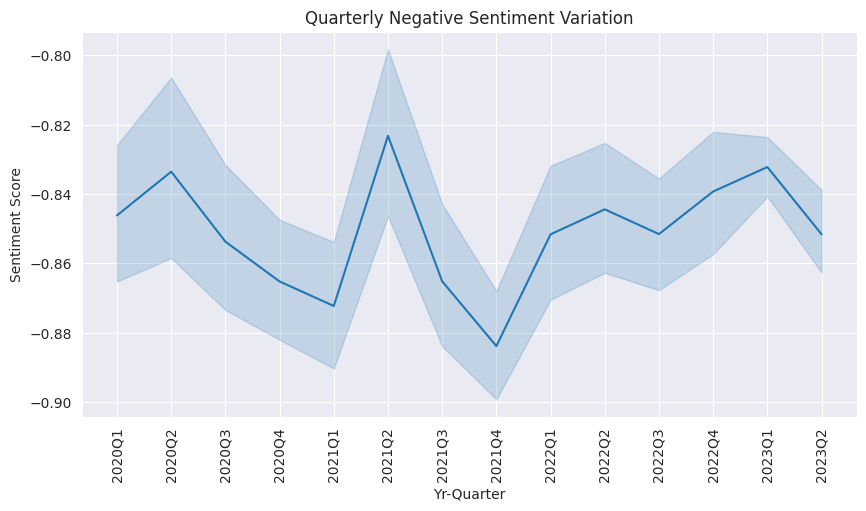

In [11]:
## Quarterly Negative sentiment variation

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
neg_df_sorted = neg_df.sort_values('quarter')  # Sort DataFrame by 'quarter' column
sns.lineplot(data = neg_df_sorted, x=neg_df_sorted['quarter'].astype('str'), y= 'sent_score', color = 'tab:blue')
plt.xlabel("Yr-Quarter")
plt.xticks(rotation = 90)
plt.ylabel("Sentiment Score")
plt.title("Quarterly Negative Sentiment Variation")

CPU times: user 25.6 s, sys: 42.2 ms, total: 25.7 s
Wall time: 25.6 s


Text(0.5, 1.0, 'Overall Positive Sentiment Variation')

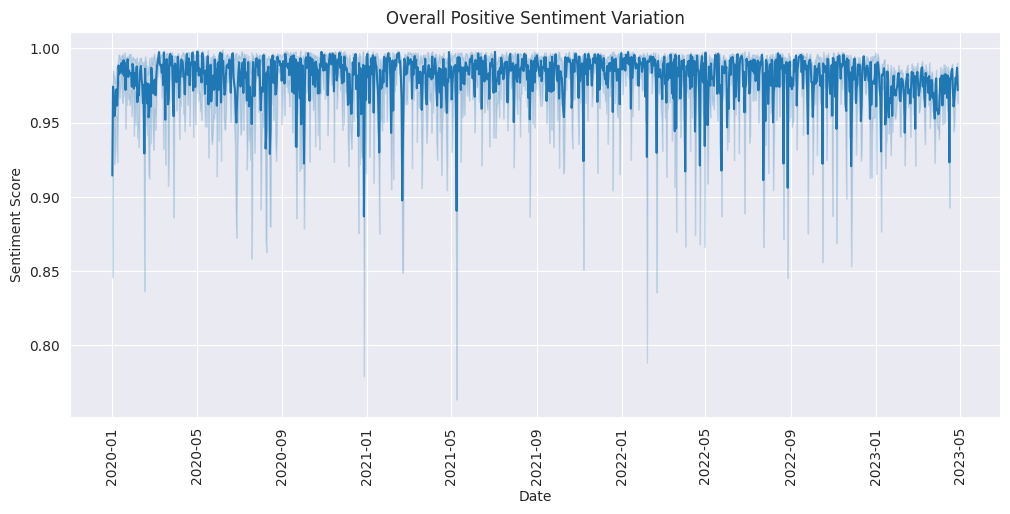

In [12]:
%%time
#Overall positive sentiment variation over time

plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.lineplot(data = pos_df, x='date', y= 'sent_score')
plt.xlabel("Date")
plt.xticks(rotation = 90)
plt.ylabel("Sentiment Score")
plt.title("Overall Positive Sentiment Variation")

CPU times: user 19.8 s, sys: 18.2 ms, total: 19.9 s
Wall time: 19.8 s


Text(0.5, 1.0, 'Overall Negative Sentiment Variation')

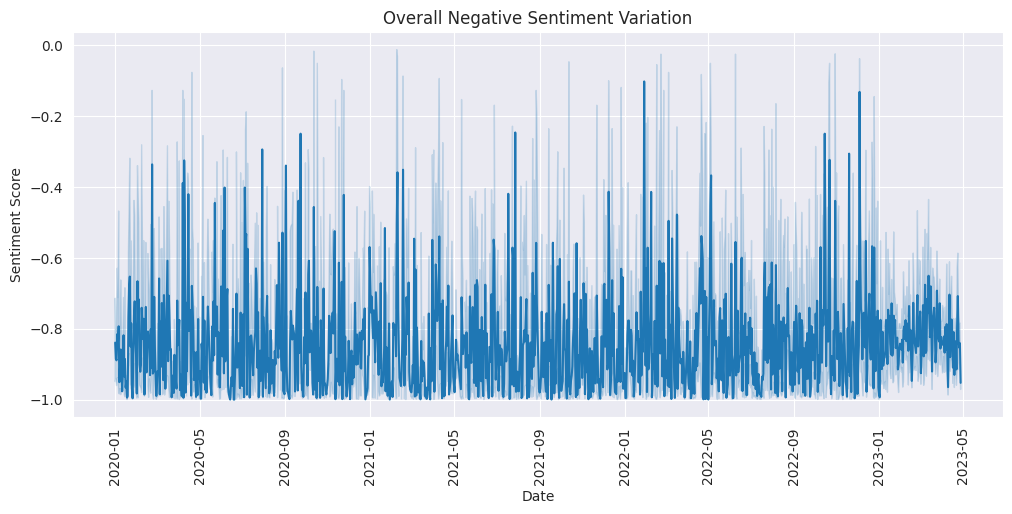

In [13]:
%%time
#Overall negative sentiment variation over time

plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.lineplot(data = neg_df, x='date', y= 'sent_score')
plt.xlabel("Date")
plt.xticks(rotation = 90)
plt.ylabel("Sentiment Score")
plt.title("Overall Negative Sentiment Variation")

Text(0.5, 1.0, 'Positive Sentiment Variation Timeline')

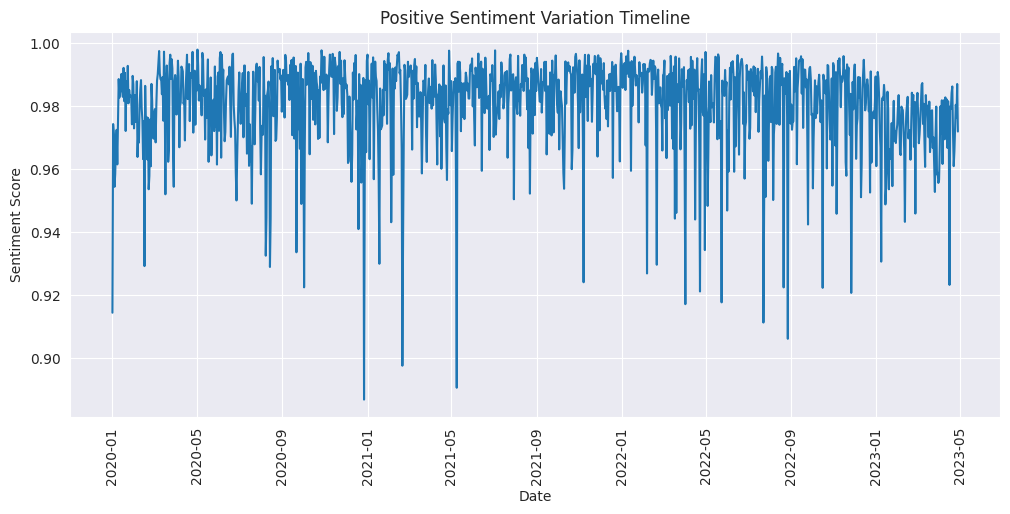

In [14]:
#Positive sentiment variation over time by average value
pos_date_df = pos_df.groupby('date')[['sent_score']].agg('mean').reset_index()

plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.lineplot(data = pos_date_df, x='date', y= 'sent_score')
plt.xlabel("Date")
plt.xticks(rotation = 90)
plt.ylabel("Sentiment Score")
plt.title("Positive Sentiment Variation Timeline")

Text(0.5, 1.0, 'Negative Sentiment Variation Timeline')

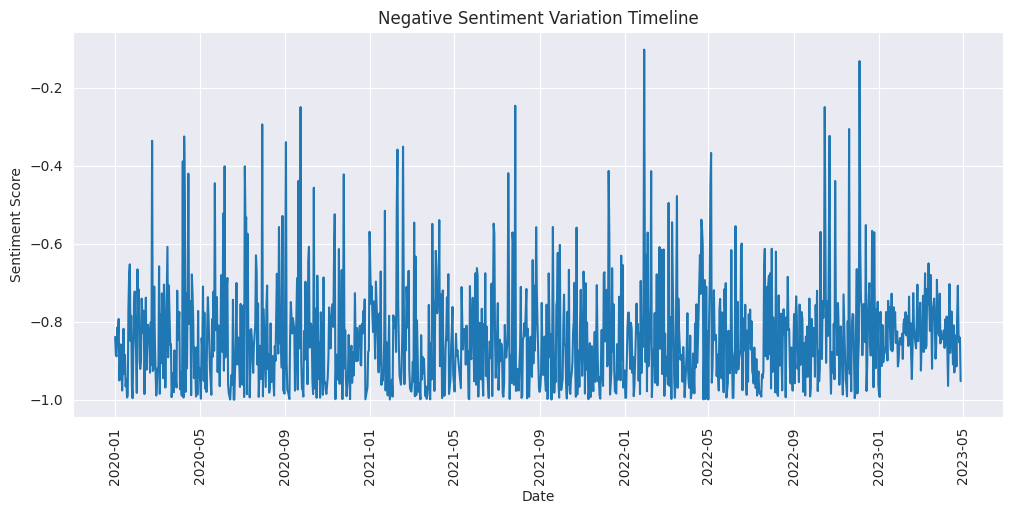

In [15]:
#Negative sentiment variation over time by average value
neg_date_df = neg_df.groupby('date')[['sent_score']].agg('mean').reset_index()

plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.lineplot(data = neg_date_df, x='date', y= 'sent_score')
plt.xlabel("Date")
plt.xticks(rotation = 90)
plt.ylabel("Sentiment Score")
plt.title("Negative Sentiment Variation Timeline")

Text(0.5, 1.0, 'Monthly Positive Sentiment Variation Timeline')

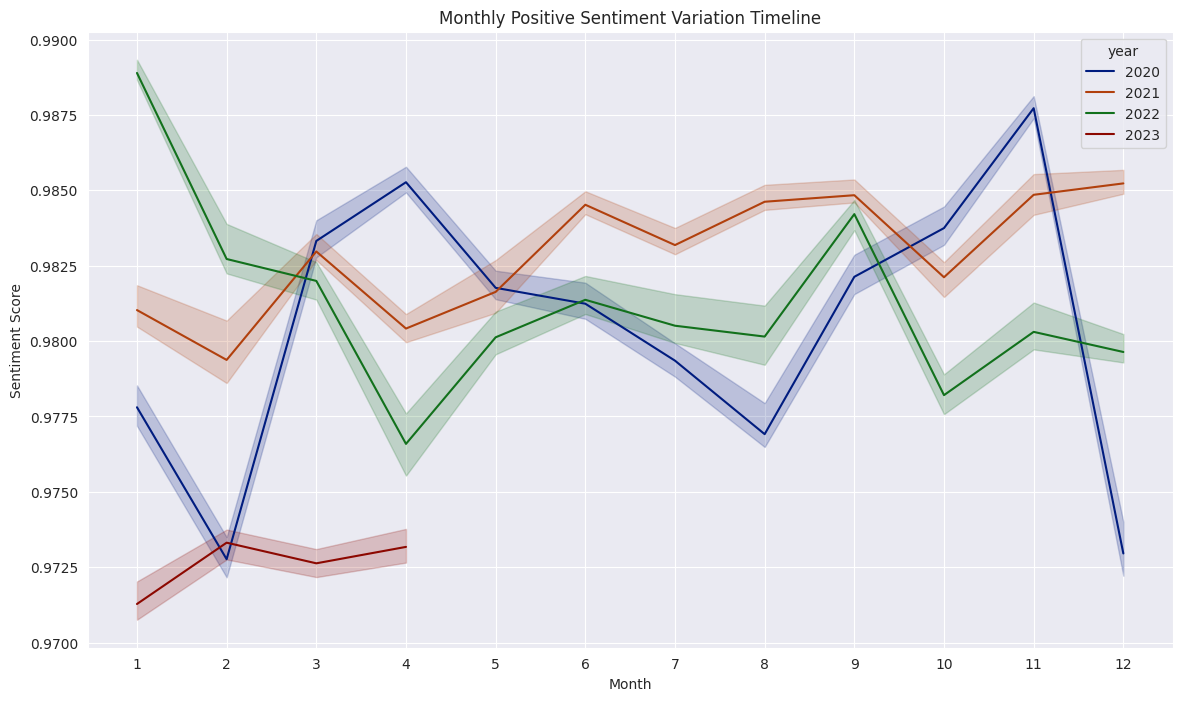

In [44]:
#Monthly Positive sentiment variation over time by average value
pos_year_df = pos_df.groupby(['year','month','date'])[['sent_score']].agg('mean').reset_index()

plt.figure(figsize=(14,8))
sns.set_style('darkgrid')
sns.lineplot(data = pos_year_df, x='month', y= 'sent_score', hue ='year', palette = "dark", ci=20)
plt.xlabel("Month")
plt.xticks(ticks = list(range(1,13)),rotation = 0)
plt.ylabel("Sentiment Score")
plt.title("Monthly Positive Sentiment Variation Timeline")

Text(0.5, 1.0, 'Monthly Negative Sentiment Variation Timeline')

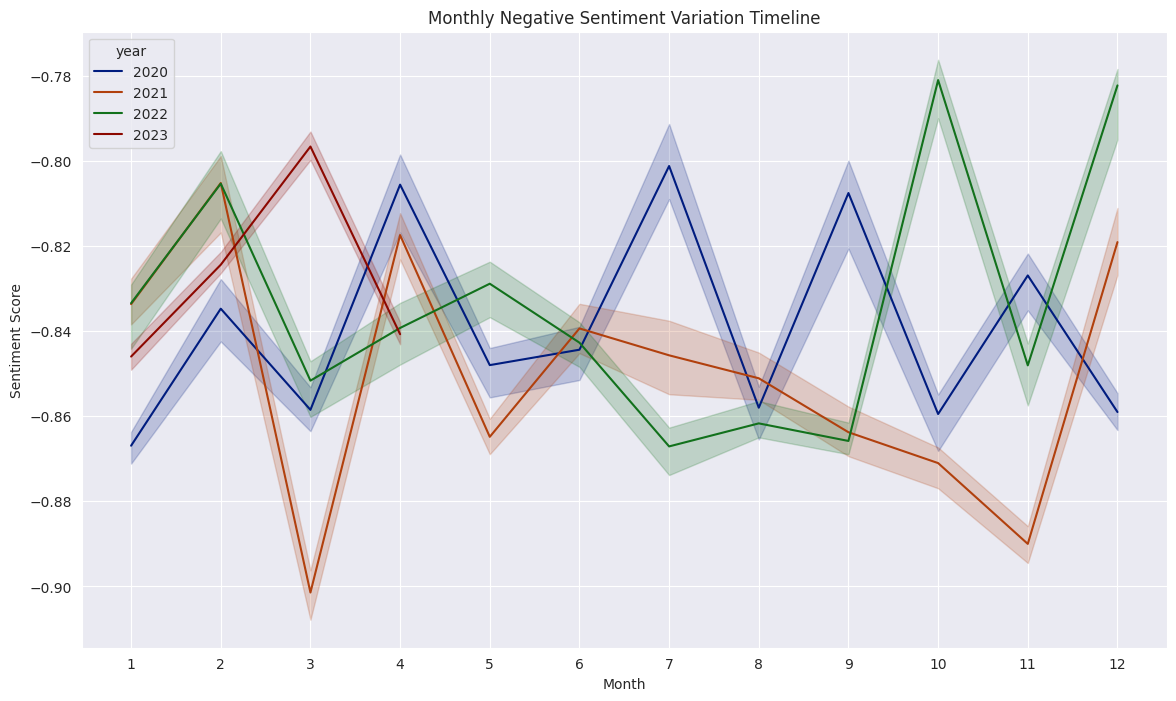

In [43]:
#Monthly Negative sentiment variation over time by average value
neg_year_df = neg_df.groupby(['year','month','date'])[['sent_score']].agg('mean').reset_index()

plt.figure(figsize=(14,8))
sns.set_style('darkgrid')
sns.lineplot(data = neg_year_df, x='month', y= 'sent_score', hue ='year', palette = "dark", ci=20)
plt.xlabel("Month")
plt.xticks(ticks = list(range(1,13)),rotation = 0)
plt.ylabel("Sentiment Score")
plt.title("Monthly Negative Sentiment Variation Timeline")

## Building wordcloud for visually checking most frequent words being talked about in the news

In [45]:
pos_corpus = " ".join(pos_df['text_clean'])
neg_corpus = " ".join(neg_df['text_clean'])

In [55]:
stopwords = set(wordcloud.STOPWORDS)
stopwords.update(["will","Subscribe","See", "stories","year","Friday","Aug","years", "hours","use","said",
                  "share","company","will", "new","best","using","world","app","system","used","work",
                  "experience","News","one","help","Sign","Term","terms", "Culture"])

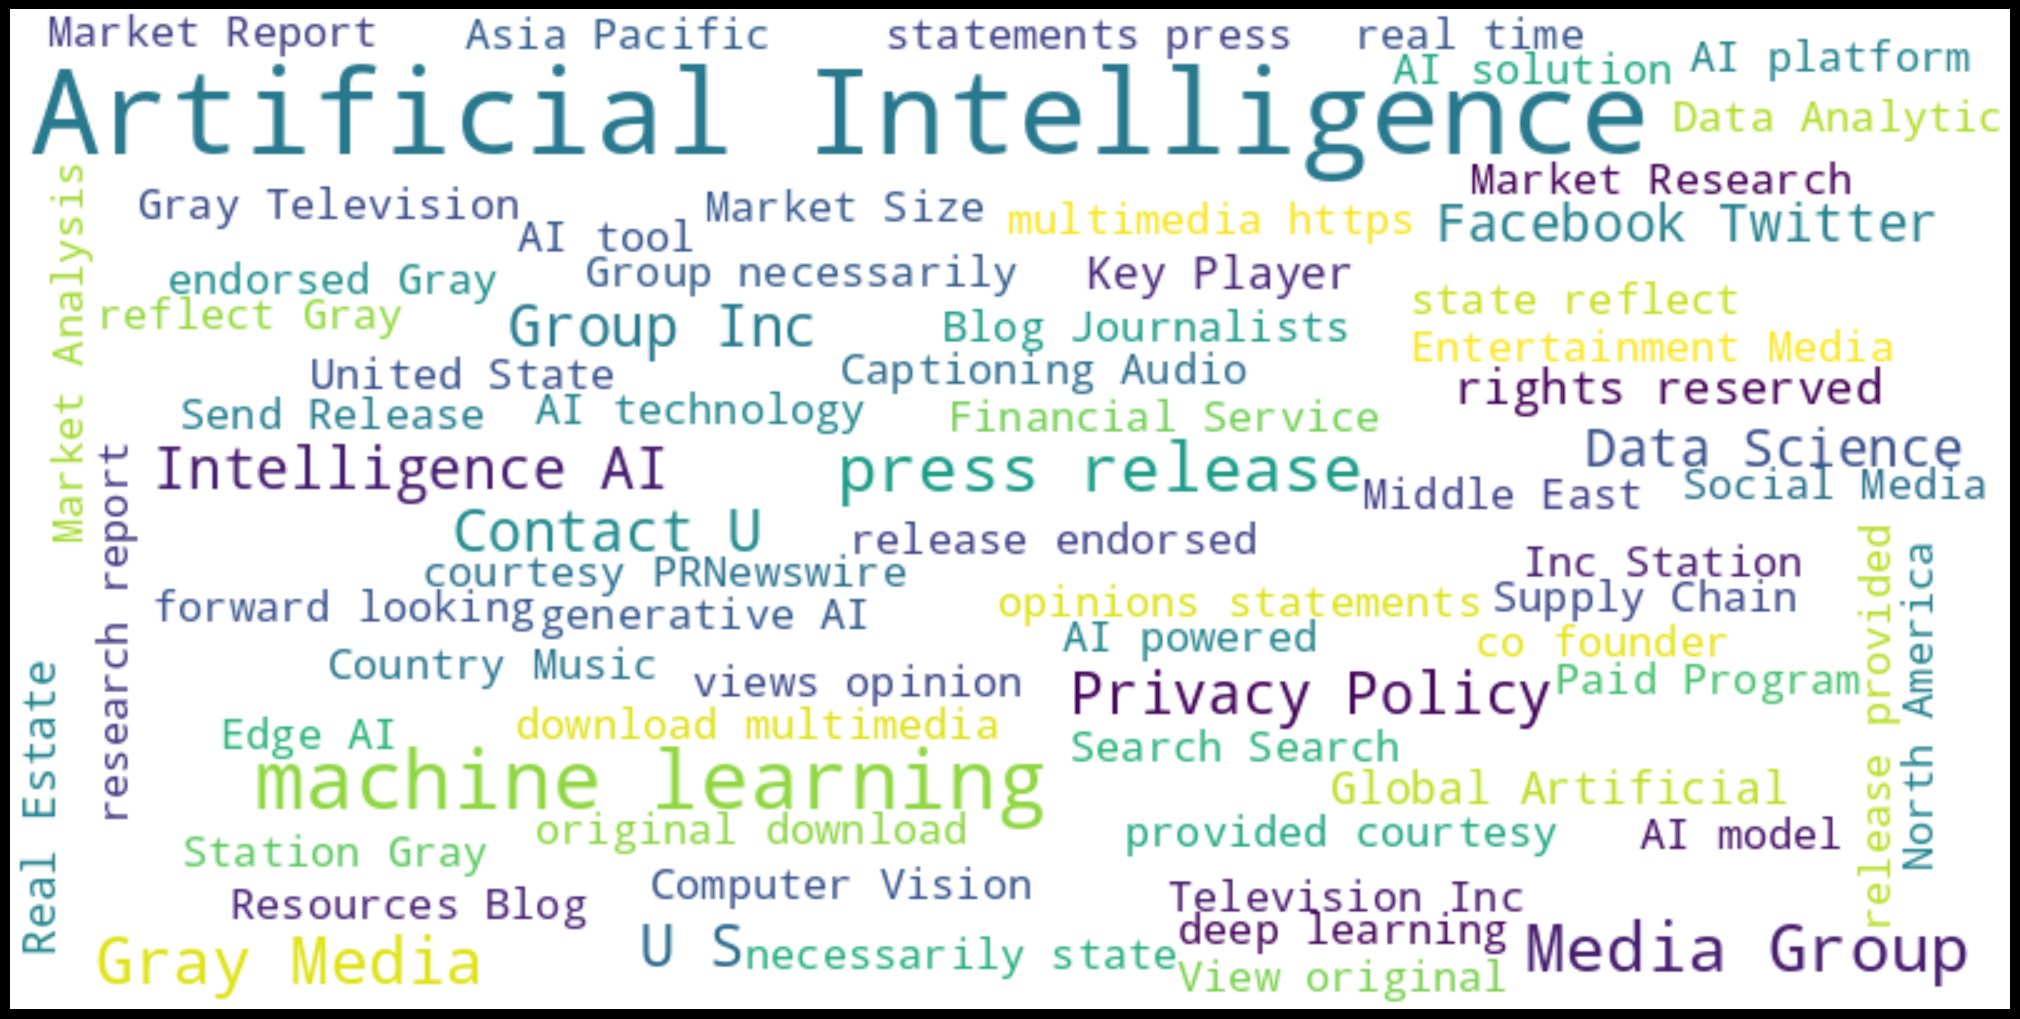

CPU times: user 7min 22s, sys: 20.1 s, total: 7min 42s
Wall time: 7min 41s


In [56]:
%%time
pos_wordcloud_obj = wordcloud.WordCloud(
    width = 800,
    height = 400,
    background_color = 'white',
    max_words=70,
    stopwords = stopwords)

pos_wordcloud_obj.generate(pos_corpus)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(pos_wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

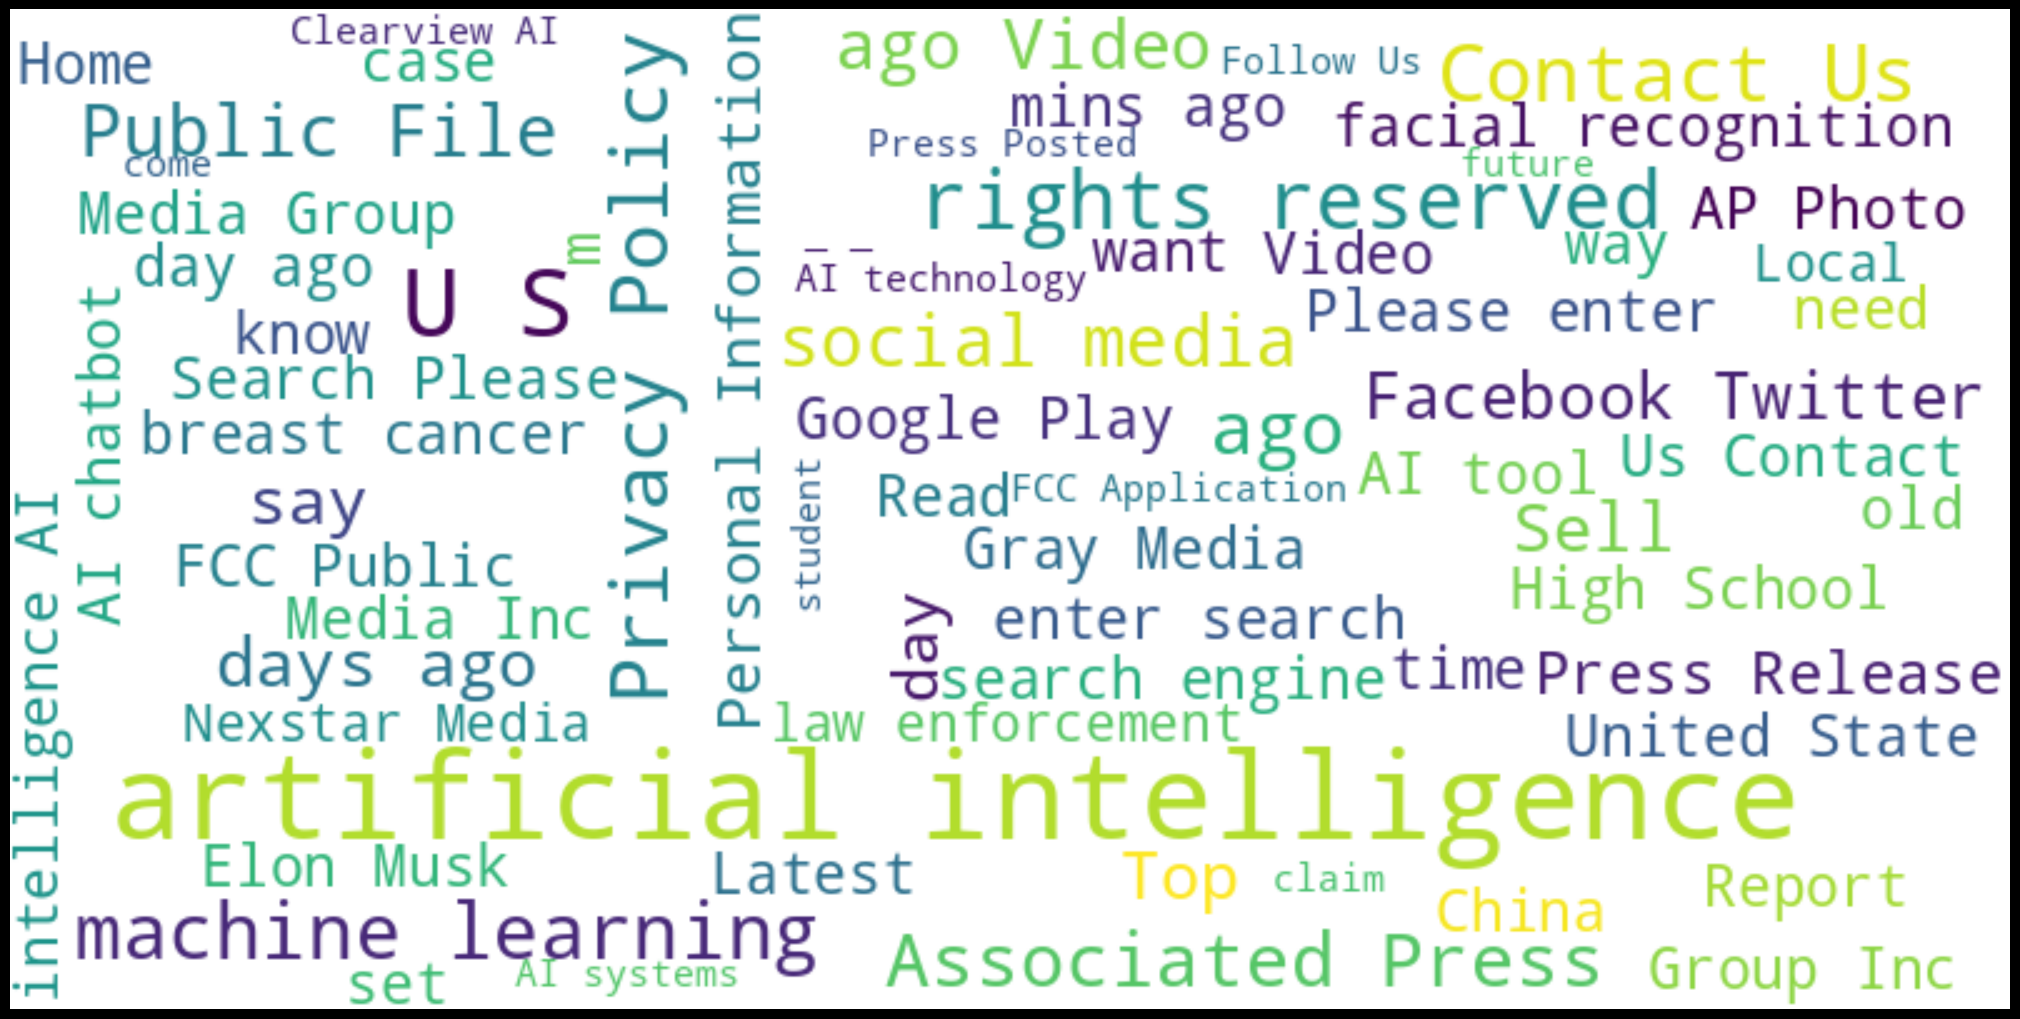

CPU times: user 35.9 s, sys: 1.56 s, total: 37.5 s
Wall time: 37.1 s


In [57]:
%%time
neg_wordcloud_obj = wordcloud.WordCloud(
    width = 800,
    height = 400,
    background_color = 'white',
    max_words=70,
    stopwords = stopwords)

neg_wordcloud_obj.generate(neg_corpus)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(neg_wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [20]:
import datetime
import time
import pytz
datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sun, 21 May 2023 18:38:20'